In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [2]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

# Generator

In [13]:
base_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)




Found 100000 images belonging to 2 classes.


In [4]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# Train Model DenseNet   

In [14]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(densenet)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [16]:
train_steps = 100000//64
valid_steps = 20000//64

history = model.fit_generator(
    train_flow,
    epochs = 10,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps
)

Train for 1562 steps, validate for 312 steps
Epoch 1/10
1562/1562 [==============================] - 626s 401ms/step - loss: 0.5267 - accuracy: 0.7306 - val_loss: 0.5864 - val_accuracy: 0.7350
Epoch 2/10
1562/1562 [==============================] - 626s 401ms/step - loss: 0.3204 - accuracy: 0.8616 - val_loss: 0.3838 - val_accuracy: 0.8302
Epoch 3/10
1562/1562 [==============================] - 624s 400ms/step - loss: 0.1853 - accuracy: 0.9256 - val_loss: 0.3160 - val_accuracy: 0.8630
Epoch 4/10
1562/1562 [==============================] - 623s 399ms/step - loss: 0.1143 - accuracy: 0.9555 - val_loss: 0.2638 - val_accuracy: 0.9045
Epoch 5/10
1562/1562 [==============================] - 624s 399ms/step - loss: 0.0771 - accuracy: 0.9710 - val_loss: 0.2181 - val_accuracy: 0.9152
Epoch 6/10
1562/1562 [==============================] - 624s 399ms/step - loss: 0.0562 - accuracy: 0.9788 - val_loss: 0.1217 - val_accuracy: 0.9543
Epoch 7/10
1562/1562 [==============================] - 623s 399ms/

# Evaluation

In [ ]:
#model.save('completed_trained_model.h5')

In [17]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

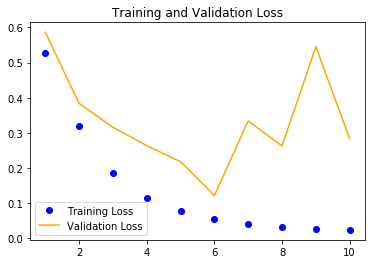

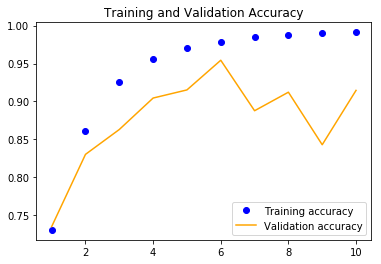

In [19]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [20]:
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
y_pred = model.predict(test_flow)
y_test = test_flow.classes

Found 20000 images belonging to 2 classes.


In [21]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.992412935
AP Score: 0.9915270175017084

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     10000
           1       0.86      1.00      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.93      0.92      0.91     20000
weighted avg       0.93      0.92      0.91     20000

